In [35]:
from rasterio.merge import merge
import rasterio
import os
import numpy as np
from affine import Affine
from rasterio.plot import show

In [29]:
def mosaic(strt=20200220,
           fin=20201016,
           in_pth='/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/',
           one_region=False
        ):
    
    landsat_out_B2 = f'LC08_L1GT_184113_184114_{strt}_B2_merge.tif'
    landsat_out_B3 = f'LC08_L1GT_184113_184114_{strt}_B3_merge.tif'
    landsat_out_B4 = f'LC08_L1GT_184113_184114_{strt}_B4_merge.tif'
    
    regions = (184113,184114)
    if one_region: regions = [184114]
    landsat_names_B2 = []
    landsat_names_B3 = []
    landsat_names_B4 = []
    
    for reg in regions:
        landsat_names_B2.append(
            f'LC08_L1GT_{reg}_{strt}_{fin}_02_T2/LC08_L1GT_{reg}_{strt}_{fin}_02_T2_B2.TIF')
        landsat_names_B3.append(
            f'LC08_L1GT_{reg}_{strt}_{fin}_02_T2/LC08_L1GT_{reg}_{strt}_{fin}_02_T2_B3.TIF')
        landsat_names_B4.append(
            f'LC08_L1GT_{reg}_{strt}_{fin}_02_T2/LC08_L1GT_{reg}_{strt}_{fin}_02_T2_B4.TIF')

    B2_files_to_mosaic = []
    B3_files_to_mosaic = []
    B4_files_to_mosaic = []

    for fp2 in landsat_names_B2:
        src2 = rasterio.open(os.path.join(in_pth,fp2))
        B2_files_to_mosaic.append(src2)

    mosaic_B2, out_trans_B2 = merge(B2_files_to_mosaic)

    for fp3 in landsat_names_B3:
        src3 = rasterio.open(os.path.join(in_pth,fp3))
        B3_files_to_mosaic.append(src3)

    mosaic_B3, out_trans_B3 = merge(B3_files_to_mosaic)

    for fp4 in landsat_names_B4:
        src4 = rasterio.open(os.path.join(in_pth,fp4))
        B4_files_to_mosaic.append(src4)

    mosaic_B4, out_trans_B4 = merge(B4_files_to_mosaic)

    out_meta = src2.meta.copy()
    out_meta.update({'driver': 'GTiff',
                     'dtype': 'uint16',
                     'nodata': 0.0,
                     'width': mosaic_B2.shape[2],
                     'height': mosaic_B2.shape[1],
                     'count': 1,
                     'transform': out_trans_B2
                    })

    with rasterio.open(os.path.join(in_pth,landsat_out_B2), "w", **out_meta) as dest:
        dest.write(mosaic_B2)

    with rasterio.open(os.path.join(in_pth,landsat_out_B3), "w", **out_meta) as dest:    
        dest.write(mosaic_B3)

    with rasterio.open(os.path.join(in_pth,landsat_out_B4), "w", **out_meta) as dest:   
        dest.write(mosaic_B4)    

    img1_2 = rasterio.open(os.path.join(in_pth,landsat_out_B2))
    img1_3 = rasterio.open(os.path.join(in_pth,landsat_out_B3))
    img1_4 = rasterio.open(os.path.join(in_pth,landsat_out_B4))

    # crop to 99th percentile (stops dull images)
    maxpct = 90
    image1_2 = img1_2.read(1)
    image1_2[image1_2 > np.percentile(image1_2,maxpct)] = np.percentile(image1_2,maxpct)
    image1_3 = img1_3.read(1)
    image1_3[image1_3 > np.percentile(image1_3,maxpct)] = np.percentile(image1_3,maxpct)
    image1_4 = img1_4.read(1)
    image1_4[image1_4 > np.percentile(image1_4,maxpct)] = np.percentile(image1_4,maxpct)

    image1 = np.array([image1_4, image1_3, image1_2]).transpose(1,2,0)
    norm1 = (image1 * (255 / np.max(image1))).astype(np.uint8)

    np.savez(f'data/LC08_L1GT_184113_184114_{strt}_mosaic.npz',norm1)

In [20]:
mosaic(strt=20200220,fin=20201016) 

In [21]:
mosaic(strt=20210206,fin=20210302) 

In [43]:
mosaic(strt=20211020,fin=20211026) 

In [30]:
mosaic(strt=20211105,fin=20211116,one_region=True) 

In [44]:
# Load the .npz file
loaded_data = np.load(f'data/LC08_L1GT_184113_184114_20211020_mosaic.npz')

# Assuming the array was saved as 'arr_0' by default, load it as 'norm1'
norm2 = loaded_data['arr_0']

# Create the Affine object with the same parameters
transform_info = Affine(30.0, 0.0, -819915.0, 0.0, -30.0, 1635615.0)

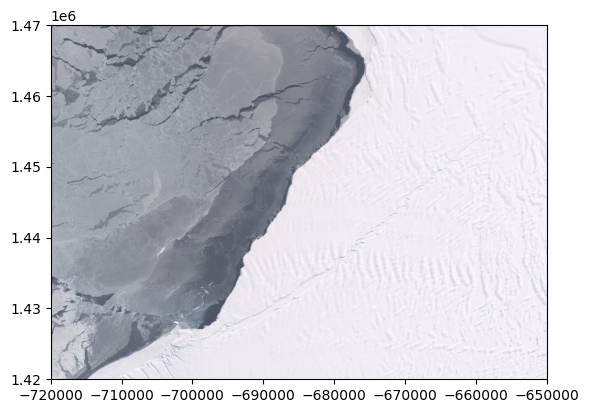

In [51]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
show(norm2.transpose(2, 0, 1), transform=transform_info,ax=ax)
plt.ylim([1420e3,1470e3])
plt.xlim([-720e3,-650e3])
plt.show()